In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import itertools
import statsmodels.stats.multitest as multi
import scipy.stats
import upsetplot
import networkx as nx

In [2]:
guardant_table = pd.read_excel('../data/Leshchiner_et_al_Tables.xlsx', sheet_name='SuppTable2_GuardantDatabase')
last_sample_dict = {}
for p, df in guardant_table.groupby('patient_id'):
    last_sample_dict[p] = df['test_id'].str[-2:].astype(int).max()
last_sample_table = guardant_table.loc[guardant_table['test_id'].str[-2:].astype(int) == guardant_table['patient_id'].apply(last_sample_dict.__getitem__)]

In [3]:
classifier_results = pd.read_excel('../data/GuardantClassifierAnnotations_12172023.xlsx', sheet_name='Sheet1', index_col=0)

In [4]:
er_patients = classifier_results.loc[classifier_results['ER_final'] == 'ER+'].index
her2_patients = classifier_results.loc[classifier_results['HER2_final'] == 'HER2+'].index
tn_patients = classifier_results.loc[classifier_results['TN_final'] == 'TN'].index

In [5]:
gene = 'ESR1'

sub_table = last_sample_table.loc[last_sample_table['patient_id'].isin(er_patients) & \
                                  (last_sample_table['alteration'] != 'AMP'),
                                  ['patient_id', 'gene', 'alteration', 'cdna']].drop_duplicates()
sub_table.loc[sub_table['gene'] == gene, 'protein_change'] = gene + '_' + sub_table['alteration']
sub_table.loc[sub_table['gene'] != gene, 'protein_change'] = sub_table['gene']
mutation_rate_by_sample = sub_table.groupby('patient_id').size()
mutation_rate_by_pc = sub_table.groupby('protein_change').size()
mutation_prob_by_pc = mutation_rate_by_pc / mutation_rate_by_pc.sum()
alt_df = sub_table.groupby(['patient_id', 'protein_change']).size().unstack().fillna(0).astype(bool).astype(int)
common_alts = alt_df.loc[:, alt_df.columns.str.startswith(gene) & np.array(alt_df.columns.map(lambda s: s.split('_')[-1][0] != s.split('_')[-1][-1]))].sum(axis='index').sort_values(ascending=False).head(9).index
alt_idx = {alt: alt_df.columns.get_loc(alt) for alt in common_alts}
alt_counts = sub_table.loc[sub_table['gene'] == gene].groupby('alteration').size().sort_values(ascending=False)[common_alts.str[len(gene) + 1:]]

In [6]:
ESR1_doms = {(42, 181): 'Oestrogen receptor', (184, 252): 'zf-C4', (327, 524): 'Hormone receptor', (552, 595): 'ESR1_C'}

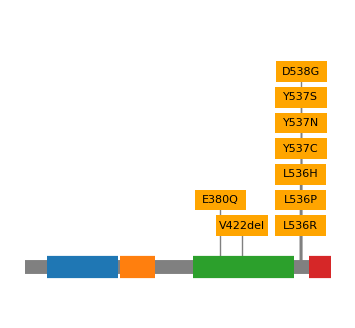

In [7]:
plt.figure(figsize=(5, 4))
ax = plt.gca()
plt.axis('off')

ax.plot([0, 595], [0, 0], lw=10, color='gray', solid_capstyle='butt')
for dom in ESR1_doms:
    ax.plot(dom, [0, 0], lw=16, solid_capstyle='butt')

heights = {80: []}
for alt in reversed(common_alts):
    if alt == 'AMP' or alt == 'splice alt':
        continue
    pos = int(''.join(filter(str.isnumeric, alt.split('_')[1])))
    h = 80
    while any([x < pos + 50 and x > pos - 50 for x in heights[h]]) or h < alt_counts[alt.split('_')[1]] / 5:
        h += 50
        heights.setdefault(h, [])
    heights[h].append(pos)
    ax.plot([pos, pos], [0, h], lw=1, color='gray', zorder=-1)
    patch = patches.Rectangle((pos - 50, h - 20), width=100, height=40, ec=None, fc='orange')
    ax.add_patch(patch)
    ax.annotate(alt.split('_')[1].replace('p.Val', 'V'), (pos, h), verticalalignment='center', horizontalalignment='center', fontsize=8)
ax.set_ylim(-100, 500)
ax.set_aspect('equal')
# plt.savefig('ESR1_stick_figure.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [8]:
labels = list(alt_df.columns)
perm_cooccurrences = {k: [] for k in itertools.combinations(common_alts, 2)}
np.random.seed(1)
for i in range(1000):
    print(i, end='\r')
    occurrences = np.random.choice(len(alt_df.columns), size=(len(alt_df.index), mutation_rate_by_sample.max()), p=mutation_prob_by_pc)
    occurrences_arr = np.zeros((len(alt_df.index), len(alt_df.columns)), dtype=bool)
    for ii, sample in enumerate(alt_df.index):
        occurrences_arr[ii, occurrences[ii][:mutation_rate_by_sample[sample]]] = True
    for c in itertools.combinations(common_alts, 2):
        alt1, alt2 = c
        perm_cooccurrences[c].append((occurrences_arr[:, alt_idx[alt1]] & occurrences_arr[:, alt_idx[alt2]]).sum())

In [9]:
real_cooccurrences = {}
cooccurrences_df = alt_df.T.dot(alt_df)
for c in itertools.combinations(common_alts, 2):
    alt1, alt2 = c
    real_cooccurrences[c] = cooccurrences_df.loc[alt1, alt2]

In [10]:
p_values = {}
for c in itertools.combinations(common_alts, 2):
    p = (sum(np.array(perm_cooccurrences[c]) >= real_cooccurrences[c]) + 1) / 1001
    p_values[c] = p
p_arr = np.array(sorted(p_values.values()))
eve_order = sorted(p_values, key=p_values.__getitem__)
q_arr = multi.fdrcorrection(p_arr, is_sorted=True)[1]
q_values = dict(zip(eve_order, q_arr))

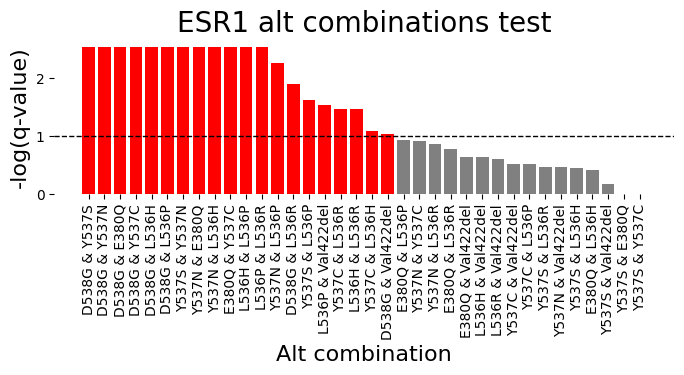

In [11]:
order = sorted(q_values, key=q_values.__getitem__)
q_values_order = np.array([q_values[c] for c in order])
plt.figure(figsize=(8, 2))
ax = plt.gca()
x = np.arange(len(order))
ax.bar(x[q_values_order <= .1], -np.log10(q_values_order[q_values_order <= .1]), color='red')
ax.bar(x[q_values_order > .1], -np.log10(q_values_order[q_values_order > .1]), color='gray')
ax.axhline(-np.log10(.1), linewidth=1, linestyle='dashed', color='k')
ax.set_xticks(x)
ax.set_xticklabels([alt1[len(gene) + 1:].replace('p.', '') + ' & ' + alt2[len(gene) + 1:].replace('p.', '') for alt1, alt2 in order], rotation='vertical')
ax.set_xlabel('Alt combination', fontsize=16)
ax.set_ylabel('-log(q-value)', fontsize=16)
ax.set_title('{} alt combinations test'.format(gene), fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# plt.savefig('ESR1_combo_test_perm.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [12]:
gene_df = last_sample_table.loc[last_sample_table['patient_id'].isin(er_patients) & \
                                (last_sample_table['gene'] == gene)]
af_df = pd.DataFrame(index=pd.unique(gene_df['patient_id']), columns=pd.unique(gene_df['alteration']))
for (p, alt), df in gene_df.groupby(['patient_id', 'alteration']):
    af_df.loc[p, alt] = df['percentage'].max()
af_df = af_df.fillna(0)

/Users/jsc333/Library/Python/3.9/lib/python/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' 'black' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' 'black' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#000

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

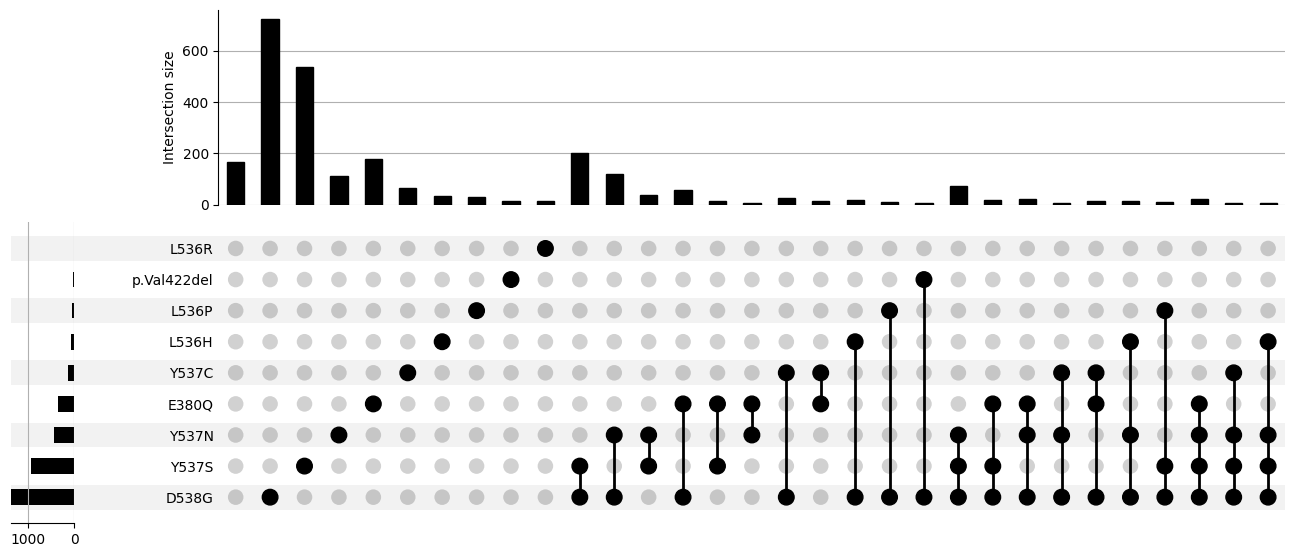

In [13]:
memberships = []
for p, df in gene_df.groupby('patient_id'):
    memberships.append([])
    for alt in common_alts:
        if alt.split('_')[1] in df['alteration'].values:
            memberships[-1].append(alt.split('_')[1])
input_ser = upsetplot.from_memberships(memberships).groupby(level=list(range(9))).size()
input_ser = input_ser[input_ser > 5]
upsetplot.plot(input_ser)
# plt.savefig('ESR1_upset_plot.pdf', format='pdf')

In [14]:
one_sided_p = {}
proportion = {}
n_patients_dict = {}

for c in itertools.combinations(common_alts, 2):
    alt1, alt2 = c
    alt1 = alt1.split('_')[1]
    alt2 = alt2.split('_')[1]
    c = alt1, alt2
    co_df = af_df.loc[(af_df[alt1] > 0) & (af_df[alt2] > 0)]
    if len(co_df) < 2:
        continue
    n_greater = (co_df[alt1] > co_df[alt2]).sum() + (co_df[alt1] == co_df[alt2]).sum() * .5
    prop = n_greater / len(co_df)
    if prop < .5:
        prop = 1 - prop
        n_greater = len(co_df) - n_greater
        c = (alt2, alt1)
    proportion[c] = prop
    one_sided_p[c] = scipy.stats.binom.cdf(len(co_df) - n_greater, len(co_df), .5)
    n_patients_dict[c] = len(co_df)

In [15]:
p_arr = np.array(sorted(one_sided_p.values()))
eve_order = sorted(one_sided_p, key=one_sided_p.__getitem__)
rank_arr = np.arange(1, len(p_arr) + 1)
q_arr = multi.fdrcorrection(p_arr, is_sorted=True, alpha=.1)[1]
q_values = dict(zip(eve_order, q_arr))

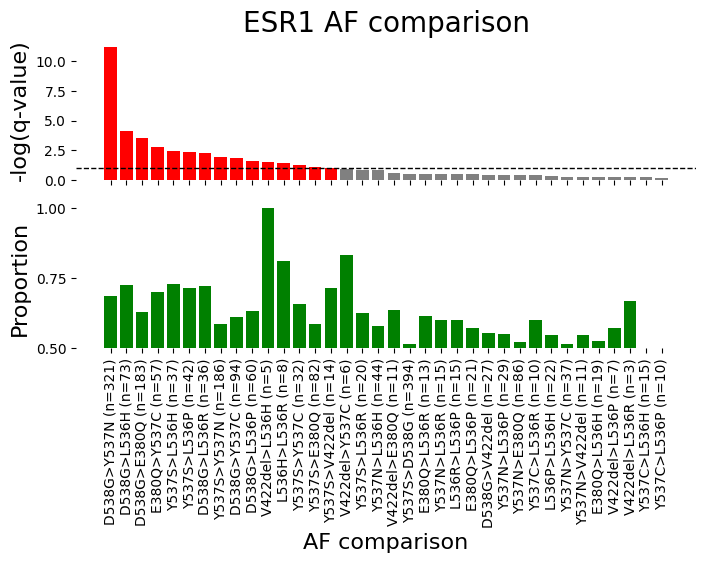

In [16]:
fig, axes = plt.subplots(figsize=(8, 4), nrows=2, sharex=True)
order = np.array(sorted(q_values.values())) 
label_order = sorted(q_values, key=q_values.__getitem__)
proportion_order = np.array([proportion[c] for c in label_order])
q_values_order = np.array([one_sided_p[c] for c in label_order])
labels = ['{}>{} (n={})'.format(alt1.replace('p.Val', 'V'), alt2.replace('p.Val', 'V'), n_patients_dict[(alt1, alt2)]) for alt1, alt2 in label_order]
x = np.arange(len(label_order))
axes[0].bar(x[q_values_order <= .1], -np.log10(q_values_order[q_values_order <= .1]), color='red')
axes[0].bar(x[q_values_order > .1], -np.log10(q_values_order[q_values_order > .1]), color='gray')
axes[0].axhline(-np.log10(.1), linewidth=1, linestyle='dashed', color='k')
axes[0].set_ylabel('-log(q-value)', fontsize=16)
axes[0].set_title('ESR1 AF comparison', fontsize=20)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

axes[1].bar(x, proportion_order, color='green')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation='vertical')
axes[1].set_yticks([.5, .75, 1])
axes[1].set_ylim(.5, 1)
axes[1].set_xlabel('AF comparison', fontsize=16)
axes[1].set_ylabel('Proportion', fontsize=16)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

# plt.savefig('ESR1_af_comp_perm.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

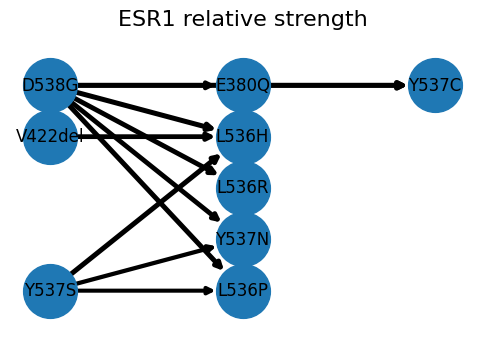

In [17]:
nodes = list(common_alts.str[len(gene) + 1:].str.replace('p.Val', 'V'))
edges = [(alt1.replace('p.Val', 'V'), alt2.replace('p.Val', 'V')) for i, (alt1, alt2) in enumerate(label_order) if q_values_order[i] < .05]
weights = [proportion[(alt1.replace('V', 'p.Val'), alt2.replace('V', 'p.Val'))] * 5 for alt1, alt2 in edges[:-1]]
DG = nx.DiGraph()
for node in nodes:
    DG.add_node(node)
for edge in edges:
    DG.add_edge(*edge)
pos = {'D538G': (0, 0),
       'Y537S': (0, -4),
       'E380Q': (1, 0),
       'Y537C': (2, 0),
       'L536P': (1, -4),
       'L536R': (1, -2),
       'Y537N': (1, -3),
       'L536H': (1, -1),
       'V422del': (0, -1)}
plt.figure(figsize=(6, 4))
ax = plt.gca()

nx.draw_networkx(DG, pos, node_size=1500, ax=ax, width=weights)
ax.set_title('ESR1 relative strength', fontsize=16)
ax.set_ylim(-5, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# plt.savefig('ESR1_relative_strength.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()